In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

import functools
import math
from functools import partial
from typing import Any, Callable, List, Optional, Tuple, Type, Union

import diffrax
import equinox as eqx
import matplotlib.animation
import matplotlib.lines
import matplotlib.patches
import matplotlib.pyplot as plt
import optax
from jaxtyping import Array, ArrayLike, PRNGKeyArray, PyTree, Scalar
from tqdm.auto import trange

In [ ]:
def cartpole_ode(t: Scalar, y: Array, u: Array, args: PyTree) -> PyTree:
    f = 10 * u[0]

    g = 9.81
    mass_cart = 1.0
    mass_pole = 0.1
    length_pole = 0.5

    x = y[0]
    theta = y[1]
    dot_x = y[2]
    dot_theta = y[3]

    ddot_theta = (
        g * jnp.sin(theta)
        + jnp.cos(theta)
        * (
            (-f - mass_pole * length_pole * jnp.square(dot_theta) * jnp.sin(theta))
            / (mass_cart + mass_pole)
        )
    ) / (
        length_pole
        * (4 / 3 - (mass_pole * jnp.square(jnp.cos(theta)) / (mass_cart + mass_pole)))
    )

    ddot_x = (
        f
        + mass_pole
        * length_pole
        * (jnp.square(dot_theta) * jnp.sin(theta) - ddot_theta * jnp.cos(theta))
    ) / (mass_cart + mass_pole)

    dy = jnp.stack((dot_x, dot_theta, ddot_x, ddot_theta), axis=-1)
    return dy

# Control function decorators

In [ ]:
def with_control(
    f: Callable[[Scalar, PyTree, PyTree, PyTree], PyTree]
) -> Callable[[Scalar, PyTree, PyTree], PyTree]:
    @functools.wraps(f)
    def wrapper(t: Scalar, y: PyTree, args: PyTree) -> PyTree:
        control, f_args = args
        u = control(y)

        dy = f(t, y, u, f_args)
        return dy

    def modify_initial_state(control: PyTree, t0: Scalar, y0: Array) -> Array:
        return y0

    wrapper_fn = wrapper
    wrapper_fn._modify_initial_state = modify_initial_state

    return wrapper_fn


def with_derivative_control(
    f: Callable[[Scalar, PyTree, PyTree, PyTree], PyTree], num_controls: int
) -> Callable[[Scalar, PyTree, PyTree], PyTree]:
    @functools.wraps(f)
    def wrapper(t: Scalar, y: PyTree, args: PyTree) -> PyTree:
        control, f_args = args
        c_u, f_y = y[..., :num_controls], y[..., num_controls:]

        f_dy = f(t, f_y, c_u, f_args)
        c_du = control(y)

        dy = jnp.concatenate((c_du, f_dy), axis=-1)
        return dy

    def modify_initial_state(control: PyTree, t0: Scalar, y0: Array) -> Array:
        X0 = jnp.concatenate((t0, y0), axis=-1)
        c0 = control.encode_controls(X0)

        # c0 = jnp.zeros(num_controls)

        y0 = jnp.concatenate((c0, y0), axis=-1)
        return y0

    wrapper_fn = wrapper
    wrapper_fn._modify_initial_state = modify_initial_state

    return wrapper_fn


# This needs stepping support, since ODE RNNs are discontinuous over state changes
# def with_ode_rnn_control(f: Callable[[Scalar, PyTree, PyTree, PyTree], PyTree], num_controls: int, num_memory: int):


def with_cde_rnn_control(
    f: Callable[[Scalar, PyTree, PyTree, PyTree], PyTree], num_latents: int
):
    @functools.wraps(f)
    def wrapper(t: Scalar, y: PyTree, args: PyTree) -> PyTree:
        control, f_args = args
        f_y, c_z = y[..., :-num_latents], y[..., -num_latents:]

        c_u = control.decode_latents(c_z)
        f_dy = f(t, f_y, c_u, f_args)

        dt = jnp.ones(1)
        dX = jnp.concatenate((dt, f_dy[:2]), axis=-1)

        c_dzdX = control(c_z)
        c_dz = c_dzdX @ dX

        dy = jnp.concatenate((f_dy, c_dz), axis=-1)
        return dy

    def modify_initial_state(control: PyTree, t0: Scalar, y0: Array) -> Array:
        X0 = jnp.concatenate((t0, y0[:2]), axis=-1)
        z0 = control.encode_latents(X0)

        y0 = jnp.concatenate((z0, y0), axis=-1)
        return y0

    wrapper_fn = wrapper
    wrapper_fn._modify_initial_state = modify_initial_state

    return wrapper_fn

# Active Control Test (with generic interface)

In [ ]:
class RNN(eqx.Module):
    in_proj: eqx.nn.Linear
    out_proj: eqx.nn.Linear
    cells: eqx.Module
    cell_type: str
    initial_state: PyTree

    def __init__(
        self,
        in_width: int,
        out_width: int,
        rnn_width: int,
        rnn_layers: int,
        cell_type: str,
        key: PRNGKeyArray,
    ):
        key, key1, key2 = jax.random.split(key, num=3)
        self.in_proj = eqx.nn.Linear(in_width, rnn_width, key=key1)
        self.out_proj = eqx.nn.Linear(rnn_width, out_width, use_bias=False, key=key2)

        self.cell_type = cell_type
        cell_cls = {"gru": eqx.nn.GRUCell, "lstm": eqx.nn.LSTMCell}[cell_type]

        keys = jax.random.split(key, num=rnn_layers)
        make_cells = lambda k: cell_cls(
            input_size=rnn_width, hidden_size=rnn_width, key=k
        )
        self.cells = eqx.filter_vmap(make_cells)(keys)

        if cell_type == "lstm":
            self.initial_state = (
                jnp.zeros((rnn_layers, rnn_width)),
                jnp.zeros((rnn_layers, rnn_width)),
            )
        elif cell_type == "gru":
            self.initial_state = jnp.zeros((rnn_layers, rnn_width))

    def __call__(self, inputs: Array, states: PyTree) -> Tuple[Array, PyTree]:
        x = self.in_proj(inputs)

        # Scan over stack of RNN cells
        cells_jaxtypes, cell_pytypes = eqx.partition(self.cells, eqx.is_array)

        def f(carry: Array, x: Tuple[eqx.Module, PyTree]) -> Tuple[Array, PyTree]:
            input = carry
            cell_jaxtypes, state = x

            cell = eqx.combine(cell_jaxtypes, cell_pytypes)
            next_state = cell(input, state)

            if self.cell_type == "lstm":
                output, _ = next_state  # LSTM-like
            elif self.cell_type == "gru":
                output = next_state  # GRU-like

            return output, next_state

        x, next_states = jax.lax.scan(f, init=x, xs=(cells_jaxtypes, states))

        x = self.out_proj(x)
        return x, next_states


class ModularControl(eqx.Module):
    main: eqx.Module
    encoder: Optional[eqx.Module] = None
    decoder: Optional[eqx.Module] = None
    num_controls: int
    num_latents: Optional[int] = None
    num_states: Optional[int] = None
    mode: str

    def __init__(
        self,
        hidden_width: int,
        hidden_layers: int,
        num_controls: int,
        num_latents: Optional[int],
        num_states: Optional[int],
        rnn_cell_type: Optional[str],
        mode: str = "cde-rnn",
        *,
        key: PRNGKeyArray
    ):
        self.num_controls = num_controls
        self.num_latents = num_latents
        self.num_states = num_states
        self.mode = mode

        if mode == "cde-rnn":
            keys = jax.random.split(key, num=3)
            self.main = eqx.nn.MLP(
                in_size=num_latents,
                out_size=(num_latents * (1 + num_states)),
                width_size=hidden_width,
                depth=hidden_layers,
                activation=jax.nn.silu,
                final_activation=jax.nn.tanh,
                use_final_bias=False,
                key=keys[0],
            )
            self.encoder = eqx.nn.MLP(
                in_size=(1 + num_states),
                out_size=num_latents,
                width_size=hidden_width,
                depth=hidden_layers,
                activation=jax.nn.silu,
                use_final_bias=False,
                key=keys[1],
            )
            self.decoder = eqx.nn.MLP(
                in_size=num_latents,
                out_size=num_controls,
                width_size=hidden_width,
                depth=hidden_layers,
                activation=jax.nn.silu,
                final_activation=jax.nn.tanh,
                use_final_bias=False,
                key=keys[2],
            )
        if mode == "step-rnn":
            self.main = RNN(
                in_width=num_states,
                out_width=num_controls,
                rnn_width=hidden_width,
                rnn_layers=hidden_layers,
                cell_type=rnn_cell_type,
                key=key,
            )

        elif mode == "derivative":
            keys = jax.random.split(key, num=2)
            self.main = eqx.nn.MLP(
                in_size=num_states,
                out_size=num_controls,
                width_size=hidden_width,
                depth=hidden_layers,
                activation=jax.nn.silu,
                use_final_bias=False,
                key=keys[0],
            )
            self.encoder = eqx.nn.MLP(
                in_size=(1 + num_states),
                out_size=num_controls,
                width_size=hidden_width,
                depth=hidden_layers,
                activation=jax.nn.silu,
                use_final_bias=False,
                key=keys[1],
            )

    def __call__(
        self, inputs: Array, states: Optional[PyTree] = None
    ) -> Union[Array, Tuple[Array, PyTree]]:
        if self.mode == "cde-rnn":
            dzdX: Array = self.main(inputs)
            dzdX = dzdX.reshape(self.num_latents, 1 + self.num_states)

            return dzdX
        elif self.mode == "step-rnn":
            return self.main(inputs[:2], states)
        else:
            return self.main(inputs)

    def encode_controls(self, X0: Array) -> Array:
        return self.encoder(X0)

    def encode_latents(self, z0: Array) -> Array:
        return self.encoder(z0)

    def decode_latents(self, z: Array) -> Array:
        return self.decoder(z)

In [ ]:
key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
control = ModularControl(
    hidden_width=64,
    hidden_layers=2,
    num_controls=1,
    num_latents=16,
    num_states=2,
    rnn_cell_type="gru",
    mode="step-rnn",
    #mode="cde-rnn",
    key=subkey,
)

optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params=eqx.filter(control, eqx.is_array))

#env_ode = with_cde_rnn_control(cartpole_ode, num_latents=16)
# env_ode = with_control(cartpole_ode)
env_ode = cartpole_ode


def reward_fn(ys: Array) -> float:
    x_thresh = 2.0
    theta_thresh = 0.2

    x = ys[..., 0]
    theta = ys[..., 1]

    # Mark invalid states
    # invalid_state = (jnp.abs(x) > x_thresh) | (jnp.abs(theta) > theta_thresh)

    # Propagate invalid states to the right
    # _, invalid_state = jax.lax.scan(
    #    lambda carry, scan: (carry | scan, carry | scan), False, invalid_state
    # )

    # Aggregate reward over valid states
    reward = jnp.square(x) + jnp.square(theta)
    # reward = jnp.where(invalid_state, 0.0, reward)
    reward = jnp.sum(reward)

    return -reward

    # return -jnp.mean(jnp.square(ys[..., 1]))


@eqx.filter_jit
def eval_traj(
    control: eqx.Module,
    key: jax.random.KeyArray,
    trajectory_t1: float,
    step_dt: Optional[float] = None,
):
    init_y0 = jax.random.uniform(
        key,
        shape=(4,),
        minval=-0.05,
        maxval=0.05,
    )

    if step_dt is None:
        sol = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(env_ode),
            solver=diffrax.Kvaerno5(),
            t0=0.0,
            t1=trajectory_t1,
            dt0=0.01,
            y0=env_ode._modify_initial_state(control, jnp.asarray([0.0]), init_y0),
            args=(control, None),
            saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, trajectory_t1, 1024)),
            stepsize_controller=diffrax.PIDController(
                #rtol=1e-5, atol=1e-5, pcoeff=0.3, icoeff=0.3
                rtol=1e-5, atol=1e-5, pcoeff=0.0, icoeff=1.0
            ),
        )

        return sol
    else:
        valid_seq, time_seq, solution_seq, control_seq = eval_traj_stepping(
            control, trajectory_t1, init_y0, step_dt
        )

        # ts = jnp.arange(valid_seq.shape[0]) * step_dt
        ts = time_seq

        sol = diffrax.Solution(
            t0=ts[0],
            t1=ts[-1],
            ts=ts,
            ys=solution_seq,
            interpolation=None,
            stats=dict(),
            result=diffrax.RESULTS.successful,
            solver_state=None,
            controller_state=None,
            made_jump=None,
        )

        return sol


@eqx.filter_jit
def eval_traj_stepping(
    control: eqx.Module,
    trajectory_t1: float,
    init_y0: PyTree,
    step_dt: float,
) -> Tuple[Array, Array, Array, Array]:
    # This technique (essentially interrupting the solve at each control update)
    # doesn't seem that great, and gives issues on the backward pass
    # Manual stepping is probably more appropiate

    """
    # num_steps = jnp.ceil(t1 / step_dt).astype(jnp.int_)
    num_steps = int(math.ceil(t1 / step_dt))

    def step_fn(
        diffeq_solver_state: Optional[PyTree],
        diffeq_controller_state: Optional[PyTree],
        diffeq_made_jump: Optional[Any],
        control_state: PyTree,
        y0: PyTree,
        t0: float,
        t1: float,
    ) -> Tuple[diffrax.Solution, PyTree, PyTree]:
        control_values, next_control_state = control(y0, control_state)

        next_diffeq_state = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(
                lambda t, y, args: env_ode(t, y, control_values, args)
            ),
            solver=diffrax.Kvaerno5(),
            t0=t0,
            t1=t1,
            dt0=0.01,
            y0=y0,
            args=None,
            saveat=diffrax.SaveAt(
                t1=True, solver_state=True, controller_state=True, made_jump=True
            ),
            stepsize_controller=diffrax.PIDController(
                rtol=1e-5, atol=1e-5, pcoeff=0.3, icoeff=0.3
            ),
            solver_state=diffeq_solver_state,
            controller_state=diffeq_controller_state,
            made_jump=diffeq_made_jump,
        )

        return next_diffeq_state, next_control_state, control_values

    # For scanning over a bounded array, see
    # https://github.com/google/jax/issues/5642
    # https://github.com/google/jax/issues/5642

    def scan_fn(
        carry: Tuple[diffrax.Solution, PyTree], x: float
    ) -> Tuple[Tuple[diffrax.Solution, PyTree], Tuple[PyTree, PyTree]]:
        diffeq_state, control_state = carry
        t1 = x

        next_diffeq_state, next_control_state, control_output = step_fn(
            diffeq_solver_state=diffeq_state.solver_state,
            diffeq_controller_state=diffeq_state.controller_state,
            diffeq_made_jump=diffeq_state.made_jump,
            control_state=control_state,
            y0=diffeq_state.ys[-1],
            t0=diffeq_state.ts[-1],
            t1=t1,
        )

        yt1 = next_diffeq_state.ys[-1]
        return (next_diffeq_state, next_control_state), (yt1, control_output)

    # Manually do first step
    # This can't be moved into scan, since the diffeq states are None, but scan
    # expects identical shapes during all iterations
    ts = jnp.linspace(0.0, t1, num=num_steps)

    init_diffeq_state, init_control_state, init_control_values = step_fn(
        diffeq_solver_state=None,
        diffeq_controller_state=None,
        diffeq_made_jump=None,
        control_state=control.main.initial_state,
        y0=y0,
        t0=ts[0],
        t1=ts[1],
    )

    # Scan over remaining steps
    _, (scan_ys, scan_cs) = jax.lax.scan(
        scan_fn, init=(init_diffeq_state, init_control_state), xs=ts[2:]
    )

    # Assemble solution
    y01 = jnp.stack((y0, init_diffeq_state.ys[-1]), axis=0)
    ys = jnp.concatenate((y01, scan_ys), axis=0)

    full_diffeq_solution = diffrax.Solution(
        t0=ts[0],
        t1=ts[-1],
        ts=ts,
        ys=ys,
        interpolation=None,
        stats=dict(),
        result=diffrax.RESULTS.successful,
        solver_state=None,
        controller_state=None,
        made_jump=None,
    )

    return full_diffeq_solution
    """

    ## New version with manual stepping

    # Params
    max_steps = 4096
    control_steps = max_steps
    #control_steps = int(math.ceil(trajectory_t1 / step_dt))

    init_t0 = 0.0
    init_dt0 = 0.01

    term = diffrax.ODETerm(lambda t, y, args: env_ode(t, y, args[0], args[1]))
    solver = diffrax.Kvaerno5(
        nonlinear_solver=diffrax.NewtonNonlinearSolver(rtol=1e-5, atol=1e-5)
    )
    stepsize_controller: diffrax.PIDController = diffrax.PIDController(
        rtol=1e-5, atol=1e-5, pcoeff=0.3, icoeff=0.3
    )

    # Initialize solver components
    init_control_state = control.main.initial_state
    init_control_value, _ = control(init_y0, init_control_state)

    init_t1, init_stepsize_controller_state = stepsize_controller.init(
        terms=term,
        t0=init_t0,
        t1=init_t0 + init_dt0,
        y0=init_y0,
        dt0=init_dt0,
        args=(init_control_value, None),
        func=solver.func(term, init_t0, init_y0, (init_control_value, None)),
        error_order=solver.error_order(term),
    )

    init_solver_state = solver.init(
        term, init_t1, trajectory_t1, init_y0, (init_control_value, None)
    )

    valid_buffer = jnp.zeros((control_steps, 1))
    time_buffer = jnp.zeros((control_steps, 1))
    solution_buffer = jnp.zeros((control_steps, init_y0.shape[-1]))
    control_buffer = jnp.zeros((control_steps, init_control_value.shape[-1]))

    valid_buffer = valid_buffer.at[0].set(True)
    time_buffer = time_buffer.at[0].set(init_t0)
    solution_buffer = solution_buffer.at[0].set(init_y0)
    control_buffer = control_buffer.at[0].set(init_control_value)

    # Integrate ODE
    _Carry = Tuple[
        float, float, PyTree, float, PyTree, int, PyTree, PyTree, PyTree, bool
    ]

    class Carry(eqx.Module):
        t0: float
        t1: float
        y0: float
        c0: float
        control_steps: int
        solver_state: PyTree
        stepsize_controller_state: PyTree
        control_state: PyTree
        made_jump: Any
        valid_buffer: Array
        time_buffer: Array
        solution_buffer: Array
        control_buffer: Array

    def step_fn(carry: Carry) -> Carry:
        # Stepping algorithm overview
        # We are guaranteed to start the first iteration with t0 inside of the
        # controller step boundary, and a valid c0
        # At every iteration, we check if the current upper border of the integration
        # interval t1 goes past the controller step boundary. If so, we clamp it to the
        # boundary. Then, at the next step, t0 will either be the previous t1 or
        # nextafter(t1). Hence, we can always simply check if t0 is past the step
        # boundary, to decide if we need to step the controller. If so, we update
        # the control values and calculate new controller step boundaries.

        # Get controller step boundary
        ct1 = init_t0 + step_dt * (carry.control_steps + 1)

        # Is the start of the current integration interval at the controller step
        # boundary?
        # Note: Here, >= is used, because t0 could also be nextafter(ct1), so == could
        # fail in certain edge cases.
        crossed_boundary = carry.t0 >= ct1

        # If so, we increase the number of controller steps...
        next_control_steps = jnp.where(
            crossed_boundary, carry.control_steps + 1, carry.control_steps
        )

        # ... and recalculate the controller step boundary
        ct0 = init_t0 + step_dt * next_control_steps
        ct1 = init_t0 + step_dt * (next_control_steps + 1)

        # Then, with the correct step boundary, we clamp the upper border of the
        # integration interval to not go past the new boundary
        t1 = jnp.where(carry.t1 > ct1, ct1, carry.t1)

        # Get the current control values, either from the controller if the boundary
        # was crossed or the previous values if we are still in the same controller step
        c0, next_control_state = jax.lax.cond(
            crossed_boundary,
            lambda y0, c0, state: control(y0, state),
            lambda y0, c0, state: (c0, state),
            carry.y0,
            carry.c0,
            carry.control_state,
        )

        # Write solution state into buffers, if boundary was crossed
        buffer_idx = next_control_steps
        valid_buffer, time_buffer, solution_buffer, control_buffer = jax.lax.cond(
            crossed_boundary,
            lambda buffer_idx, time_values, solution_values, control_values, valid_buffer, time_buffer, solution_buffer, control_buffer: (
                valid_buffer.at[buffer_idx].set(True),
                time_buffer.at[buffer_idx].set(time_values),
                solution_buffer.at[buffer_idx].set(solution_values),
                control_buffer.at[buffer_idx].set(control_values),
            ),
            lambda buffer_idx, time_values, solution_values, control_values, valid_buffer, time_buffer, solution_buffer, control_buffer: (
                valid_buffer,
                time_buffer,
                solution_buffer,
                control_buffer,
            ),
            buffer_idx,
            carry.t0,
            carry.y0,
            c0,
            carry.valid_buffer,
            carry.time_buffer,
            carry.solution_buffer,
            carry.control_buffer,
        )

        # Attempt a step
        y1, local_error_est, dense, next_solver_state, result = solver.step(
            terms=term,
            t0=carry.t0,
            t1=t1,
            y0=carry.y0,
            args=(c0, None),
            solver_state=carry.solver_state,
            made_jump=jnp.logical_or(crossed_boundary, carry.made_jump),
        )

        (
            step_accepted,
            next_t0,
            next_t1,
            made_jump,
            next_stepsize_controller_state,
            result,
        ) = stepsize_controller.adapt_step_size(
            t0=carry.t0,
            t1=t1,
            y0=carry.y0,
            y1_candidate=y1,
            args=(c0, None),
            y_error=local_error_est,
            error_order=solver.order(term),
            controller_state=carry.stepsize_controller_state,
        )

        return Carry(
            t0=next_t0,
            t1=next_t1,
            y0=y1,
            c0=c0,
            control_steps=next_control_steps,
            solver_state=next_solver_state,
            stepsize_controller_state=next_stepsize_controller_state,
            control_state=next_control_state,
            made_jump=made_jump,
            valid_buffer=valid_buffer,
            time_buffer=time_buffer,
            solution_buffer=solution_buffer,
            control_buffer=control_buffer,
        )

    def cond_fn(carry: Carry) -> bool:
        return carry.t0 < trajectory_t1

    last = eqx.internal.while_loop(
        cond_fun=cond_fn,
        body_fun=step_fn,
        init_val=Carry(
            t0=init_t0,
            t1=init_t1,
            y0=init_y0,
            c0=init_control_value,
            control_steps=jnp.int_(0),
            solver_state=init_solver_state,
            stepsize_controller_state=init_stepsize_controller_state,
            control_state=init_control_state,
            made_jump=jnp.bool_(False),
            valid_buffer=valid_buffer,
            time_buffer=time_buffer,
            solution_buffer=solution_buffer,
            control_buffer=control_buffer,
        ),
        max_steps=4096,
        buffers=lambda carry: (
            carry.valid_buffer,
            carry.time_buffer,
            carry.solution_buffer,
            carry.control_buffer,
        ),
        kind="checkpointed",
    )

    return (
        last.valid_buffer,
        last.time_buffer,
        last.solution_buffer,
        last.control_buffer,
    )


@eqx.filter_value_and_grad
def eval_reward(
    control: eqx.Module,
    key: jax.random.KeyArray,
    batch_size: int,
    t1: float,
    step_dt: Optional[float] = None,
) -> float:
    # keys = jax.random.split(key, batch_size)
    # sol = jax.vmap(eval_traj, in_axes=(None, 0), out_axes=0)(control, keys)
    sol = eval_traj(control, key, t1, step_dt)

    reward = reward_fn(sol.ys)
    return reward


# @eqx.filter_jit
def update_step(
    control: eqx.Module,
    opt_state: optax.OptState,
    key: jax.random.KeyArray,
    t1: float,
    step_dt: Optional[float] = None,
):
    reward, grads = eval_reward(control, key, 16, t1, step_dt)
    grads = jax.tree_map(lambda x: -x, grads)

    control_params, control_static = eqx.partition(control, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params=control_params)
    control_params = optax.apply_updates(control_params, updates)

    control = eqx.combine(control_params, control_static)

    return control, opt_state, reward

In [ ]:
num_steps = 1024
max_t1 = 10.0
step_dt = 0.01
#step_dt = None

t1_schedule = jnp.geomspace(1e-2, 1e2, num=num_steps)

pbar = trange(num_steps)
for i in pbar:
    #trajectory_t1 = jnp.float64(max_t1 * (i + 1) / num_steps) # This will jit t1
    trajectory_t1 = t1_schedule[i]
    #trajectory_t1 = 10.0

    key, subkey = jax.random.split(key)
    control, opt_state, reward = update_step(control, opt_state, subkey, trajectory_t1, step_dt)

    if i % 16 == 0:
        pbar.set_postfix({"reward": reward.item(), "t1": trajectory_t1})

In [ ]:
key, subkey = jax.random.split(key)
#sol = eval_traj(control, subkey, jnp.float64(max_t1), step_dt=step_dt)
sol = eval_traj(control, subkey, 100.0, step_dt=step_dt)
#sol = eval_traj(control, subkey, 10.0, step_dt=None)

plt.figure()
plt.plot(sol.ts, sol.ys[:, :2])
plt.show()

plt.figure()
plt.plot(sol.ts, sol.ys[:, 2:])
plt.show()

plt.figure()
plt.plot(sol.ts, sol.ys[:, -4:])
plt.show()

#plt.figure()
#plt.plot(sol.ts, jax.vmap(control)(sol.ys))
#plt.show()

# Active Control Test
Train a control with the current system state as input

In [223]:
key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
#"""
control = eqx.nn.MLP(
    in_size=4,
    out_size=1,
    width_size=64,
    depth=4,
    use_final_bias=False,
    # activation=jax.nn.tanh,
    final_activation=jax.nn.tanh,
    key=subkey,
)
#"""

#import optimal_control.nn as nn
#control = nn.Siren(in_features=4, out_features=1, hidden_features=64, hidden_layers=2, key=subkey)

optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(params=eqx.filter(control, eqx.is_array))


def reward_fn(ys: Array) -> float:
    x_thresh = 2.0
    theta_thresh = 0.2

    x = ys[..., 0]
    theta = ys[..., 1]

    # Mark invalid states
    # invalid_state = (jnp.abs(x) > x_thresh) | (jnp.abs(theta) > theta_thresh)

    # Propagate invalid states to the right
    # _, invalid_state = jax.lax.scan(
    #    lambda carry, scan: (carry | scan, carry | scan), False, invalid_state
    # )

    # Aggregate reward over valid states
    reward = jnp.square(x) + jnp.square(theta)
    #reward = jnp.abs(x) + jnp.abs(theta)
    # reward = jnp.where(invalid_state, 0.0, reward)
    reward = jnp.sum(reward)

    return -reward

    # return -jnp.mean(jnp.square(ys[..., 1]))


@eqx.filter_jit
def eval_traj(control: eqx.Module, key: jax.random.KeyArray, t1: float, initrange: float):
    y0 = jax.random.uniform(
        key,
        shape=(4,),
        #minval=-initrange,
        #maxval=initrange,
        # minval=jnp.asarray([-0.5, -0.1, -5.0, -1.0]),
        # maxval=jnp.asarray([0.5, 0.1, 5.0, 1.0]),

        minval=jnp.asarray([-initrange, -initrange, -0.05, -0.05]),
        maxval=jnp.asarray([initrange, initrange, 0.05, 0.05]),
    )

    sol = diffrax.diffeqsolve(
        terms=diffrax.ODETerm(with_control(cartpole_ode)),
        solver=diffrax.Dopri5(),
        t0=0.0,
        t1=t1,
        dt0=0.01,
        y0=y0,
        args=(control, None),
        saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, t1, 1024)),
        stepsize_controller=diffrax.PIDController(
            rtol=1e-5, atol=1e-5, pcoeff=1.0, icoeff=1.0
        ),
    )

    return sol

@eqx.filter_value_and_grad
def eval_reward(
    control: eqx.Module, key: jax.random.KeyArray, batch_size: int, t1: float, initrange: float
) -> float:
    #keys = jax.random.split(key, batch_size)
    #sol = jax.vmap(eval_traj, in_axes=(None, 0, None, None), out_axes=0)(control, keys, t1, initrange)
    sol = eval_traj(control, key, t1, initrange)

    reward = reward_fn(sol.ys)
    return reward


@eqx.filter_jit
def update_step(
    control: eqx.Module, opt_state: optax.OptState, key: jax.random.KeyArray, t1: float, initrange: float
):
    reward, grads = eval_reward(control, key, 16, t1, initrange)
    grads = jax.tree_map(lambda x: -x, grads)

    control_params, control_static = eqx.partition(control, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params=control_params)
    control_params = optax.apply_updates(control_params, updates)

    control = eqx.combine(control_params, control_static)

    return control, opt_state, reward

In [224]:
num_steps = 1024 * 16
t1_schedule = jnp.geomspace(1e-2, 1e2, num=num_steps)
init_schedule = jnp.geomspace(0.05, 0.05, num=num_steps)

pbar = trange(num_steps)
for i in pbar:
    # t1 = jnp.float64(10 * (i + 1) / (1024 * 16))
    t1 = t1_schedule[i]
    initrange = init_schedule[i]

    key, subkey = jax.random.split(key)
    control, opt_state, reward = update_step(control, opt_state, subkey, t1, initrange)

    if i % 16 == 0:
        pbar.set_postfix({"reward": reward.item(), "t1": t1, "initrange": initrange})

  0%|          | 0/16384 [00:00<?, ?it/s]

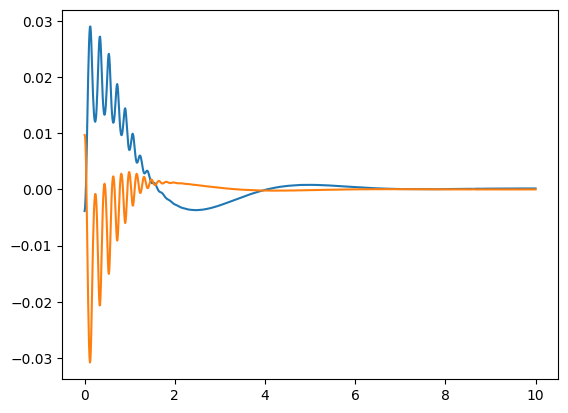

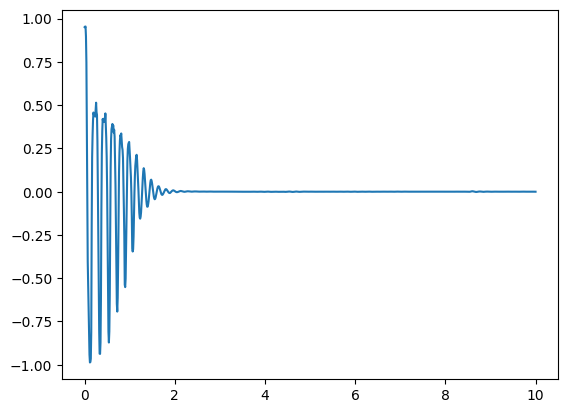

In [225]:
key, subkey = jax.random.split(key)
sol = eval_traj(control, subkey, jnp.float64(10.0), jnp.float64(0.05))

plt.figure()
plt.plot(sol.ts, sol.ys[:, :2])
plt.show()

plt.figure()
plt.plot(sol.ts, jax.vmap(control)(sol.ys))
plt.show()

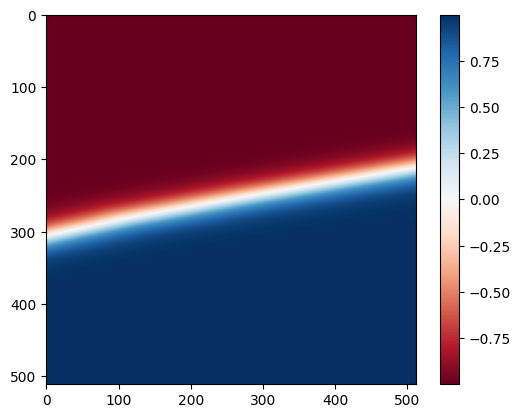

In [228]:
x = jnp.linspace(-0.1, 0.1, 512)
theta = jnp.linspace(-0.1, 0.1, 512)

x, theta = jnp.meshgrid(x, theta)
coords = jnp.stack((x.flatten(), theta.flatten()), axis=-1)
coords = jnp.concatenate((coords, jnp.full_like(coords, 0.0)), axis=-1)
force = jax.vmap(control)(coords)

plt.figure()
plt.imshow(force.reshape(512, 512), cmap="RdBu")
plt.colorbar()
plt.show()

# Active control parameterizing the derivative of the control signal

In [ ]:
key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
control = eqx.nn.MLP(
    in_size=5,
    out_size=1,
    width_size=64,
    depth=2,
    use_final_bias=False,
    # activation=jax.nn.tanh,
    # final_activation=jax.nn.tanh,
    key=subkey,
)

optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params=eqx.filter(control, eqx.is_array))


def reward_fn(ys: Array) -> float:
    x_thresh = 2.0
    theta_thresh = 0.2

    x = ys[..., 0]
    theta = ys[..., 1]

    # Mark invalid states
    # invalid_state = (jnp.abs(x) > x_thresh) | (jnp.abs(theta) > theta_thresh)

    # Propagate invalid states to the right
    # _, invalid_state = jax.lax.scan(
    #    lambda carry, scan: (carry | scan, carry | scan), False, invalid_state
    # )

    # Aggregate reward over valid states
    reward = jnp.square(x) + jnp.square(theta)
    # reward = jnp.where(invalid_state, 0.0, reward)
    reward = jnp.sum(reward)

    return -reward

    # return -jnp.mean(jnp.square(ys[..., 1]))


@eqx.filter_jit
def eval_traj(control: eqx.Module, key: jax.random.KeyArray, t1: float):
    y0 = jax.random.uniform(
        key,
        shape=(4,),
        minval=-0.05,
        maxval=0.05,
        # minval=jnp.asarray([-0.5, -0.1, -5.0, -1.0]),
        # maxval=jnp.asarray([0.5, 0.1, 5.0, 1.0]),
    )

    sol = diffrax.diffeqsolve(
        terms=diffrax.ODETerm(with_derivative_control(cartpole_ode, num_controls=1)),
        solver=diffrax.Dopri5(),
        t0=0.0,
        t1=t1,
        dt0=0.01,
        y0=jnp.concatenate((jnp.zeros(1), y0)),
        args=(control, None),
        saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, t1, 1024)),
        stepsize_controller=diffrax.PIDController(
            rtol=1e-5, atol=1e-5, pcoeff=0.3, icoeff=0.3
        ),
    )

    return sol


@eqx.filter_value_and_grad
def eval_reward(
    control: eqx.Module, key: jax.random.KeyArray, batch_size: int, t1: float
) -> float:
    # keys = jax.random.split(key, batch_size)
    # sol = jax.vmap(eval_traj, in_axes=(None, 0), out_axes=0)(control, keys)
    sol = eval_traj(control, key, t1)

    reward = reward_fn(sol.ys)
    return reward


#@eqx.filter_jit
def update_step(
    control: eqx.Module, opt_state: optax.OptState, key: jax.random.KeyArray, t1: float
):
    reward, grads = eval_reward(control, key, 16, t1)
    grads = jax.tree_map(lambda x: -x, grads)

    control_params, control_static = eqx.partition(control, eqx.is_array)
    updates, opt_state = optimizer.update(grads, opt_state, params=control_params)
    control_params = optax.apply_updates(control_params, updates)

    control = eqx.combine(control_params, control_static)

    return control, opt_state, reward

In [ ]:
pbar = trange(1024 * 16)
for i in pbar:
    t1 = jnp.float64(10 * (i + 1) / (1024 * 16))

    key, subkey = jax.random.split(key)
    control, opt_state, reward = update_step(control, opt_state, subkey, t1)

    if i % 16 == 0:
        pbar.set_postfix({"reward": reward.item(), "t1": t1})

In [ ]:
key, subkey = jax.random.split(key)
sol = eval_traj(control, subkey, jnp.float64(100.0))

plt.figure()
plt.plot(sol.ts, sol.ys[:, :2])
plt.show()

plt.figure()
plt.plot(sol.ts, jax.vmap(control)(sol.ys))
plt.show()

# Animation Test

In [ ]:
fig, ax = plt.subplots()

ax.axhline()

cart_width = 0.5
cart_height = 0.25
cart = ax.add_patch(
    matplotlib.patches.Rectangle(
        [sol.ys[0, 0] - cart_width / 2, 0], cart_width, cart_height
    )
)

pole_width = 2.5
pole_length = 0.5


def get_pole_data(cart_x, pole_angle):
    pole_base_x = cart_x
    pole_base_y = cart_height
    pole_end_x = pole_base_x + math.cos(pole_angle)
    pole_end_y = pole_base_y + math.sin(pole_angle)

    return [pole_base_x, pole_end_x], [pole_base_y, pole_end_y]


pole = ax.add_line(
    matplotlib.lines.Line2D(
        *get_pole_data(sol.ys[0, 0], sol.ys[0, 1]), linewidth=pole_width
    )
)


def init():
    ax.set_xlim([-10.0, 10.0])
    ax.set_ylim([-0.5, 2.0])

    return cart, pole


def update(frame):
    y = sol.ys[frame]

    cart.set(x=y[0])
    pole.set_data(*get_pole_data(y[0], y[1]))

    return cart, pole

animation = matplotlib.animation.FuncAnimation(fig=fig, func=update, frames=range(len(sol.ts)), init_func=init)
plt.show()